In [1]:
import os
import pandas as pd
import japanize_matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

os.chdir("../")

RATE_A = "RateA"
RATE_S = "RateS"

df_yorushika = pd.read_csv("csv/ヨルシカ_20231119.csv")
df_greeeen = pd.read_csv("csv/GReeeeN_20231119.csv")

In [2]:
def preprocess(df_list):
    rates = pd.concat(df_list, axis=0)
    rates = rates.dropna(subset=["numerator_A", "denominator_A", "numerator_S", "denominator_S"])

    rates[RATE_A] = rates.numerator_A / rates.denominator_A
    rates[RATE_S] = rates.numerator_S / rates.denominator_S

    x_max = rates.RateA.max()
    x_min = rates.RateA.min()
    y_max = rates.RateS.max()
    y_min = rates.RateS.min()

    xy_max = max(x_max, y_max)
    xy_max += xy_max / xy_max / 100
    xy_min = min(x_min, y_min)
    xy_min -= xy_min / xy_min / 100

    return (rates, xy_min, xy_max)

In [3]:
def scatter(rates:pd.DataFrame, xy_min:int, xy_max:int, subset:list, sort_by:str, title: str, xlabel:str, ylabel:str):
    sorted_rates = rates.dropna(subset=subset).sort_values(sort_by, ascending=False)
    center = len(sorted_rates) // 2
    pop_youtube = sorted_rates[:center]
    unpop_youtube = sorted_rates[center:]

    plt.scatter(x=RATE_A, y=RATE_S, data=pop_youtube, color='blue', label='人気曲')
    plt.scatter(x=RATE_A, y=RATE_S, data=unpop_youtube, color='red', label='普通曲')

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.xlim(xy_min, xy_max)
    plt.ylim(xy_min, xy_max)
    plt.minorticks_on()
    plt.grid(which='major', color='gray', linestyle='solid')
    plt.grid(which='minor', color='lightgray', linestyle='dotted')

# 単語の一致率

In [4]:
rates, xy_min_wmr, xy_max_wmr = preprocess([
    pd.concat([df_yorushika, pd.read_csv("csv/ヨルシカ_wmr_20231119.csv")], axis=1),
    pd.concat([df_greeeen, pd.read_csv("csv/GReeeeN_wmr_20231119.csv")], axis=1),
])

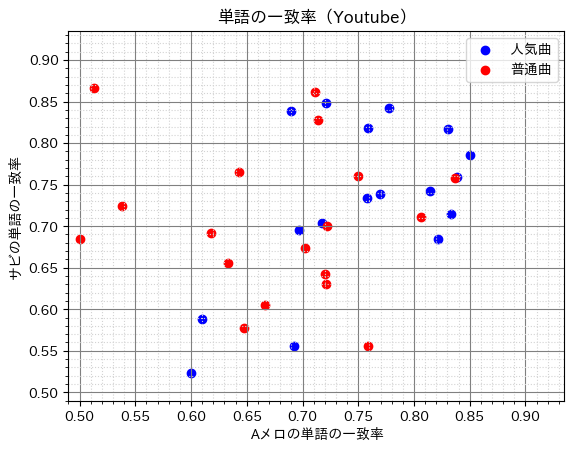

In [5]:
scatter(rates, xy_min_wmr, xy_max_wmr, ["youtube_url"], "youtube_play_times", "単語の一致率（Youtube）", "Aメロの単語の一致率", "サビの単語の一致率")

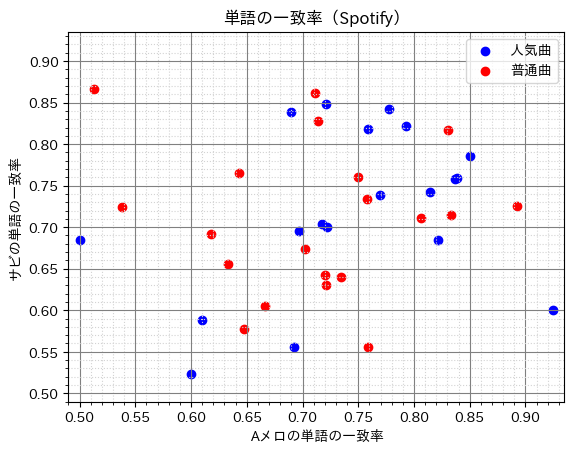

In [6]:
scatter(rates, xy_min_wmr, xy_max_wmr, ["spotify_id"], "spotify_popularity", "単語の一致率（Spotify）", "Aメロの単語の一致率", "サビの単語の一致率")

# 木構造の類似度（全部分木）

In [7]:
rates, xy_min_ts, xy_max_ts = preprocess([
    pd.concat([df_yorushika, pd.read_csv("csv/ヨルシカ_ts_20231119.csv")], axis=1),
    pd.concat([df_greeeen, pd.read_csv("csv/GReeeeN_ts_20231119.csv")], axis=1),
])

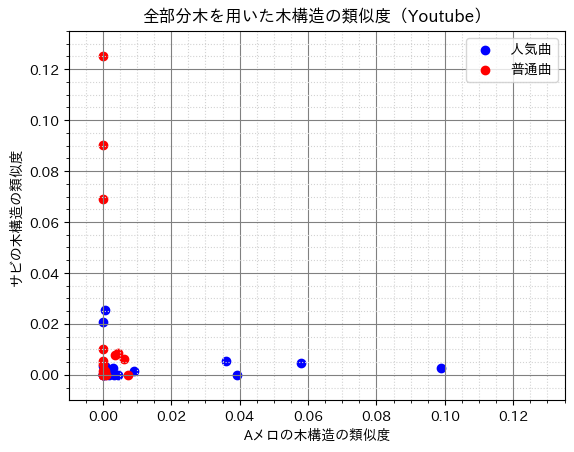

In [8]:
scatter(rates, xy_min_ts, xy_max_ts, ["youtube_url"], "youtube_play_times", "全部分木を用いた木構造の類似度（Youtube）", "Aメロの木構造の類似度", "サビの木構造の類似度")

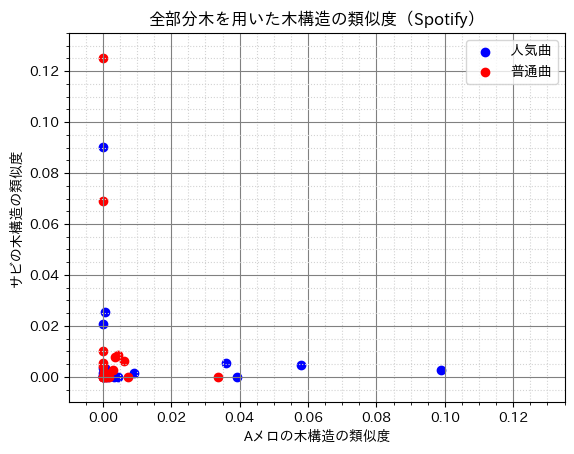

In [9]:
scatter(rates, xy_min_ts, xy_max_ts, ["spotify_id"], "spotify_popularity", "全部分木を用いた木構造の類似度（Spotify）", "Aメロの木構造の類似度", "サビの木構造の類似度")

# 木構造の類似度計算（親子）

In [10]:
rates, xy_min_tspc, xy_max_tspc = preprocess([
    pd.concat([df_yorushika, pd.read_csv("csv/ヨルシカ_tspc_20231119.csv")], axis=1),
    pd.concat([df_greeeen, pd.read_csv("csv/GReeeeN_tspc_20231119.csv")], axis=1),
])

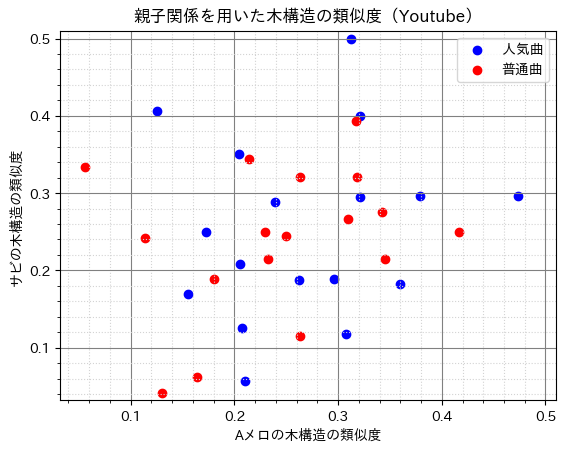

In [11]:
scatter(rates, xy_min_tspc, xy_max_tspc, ["youtube_url"], "youtube_play_times", "親子関係を用いた木構造の類似度（Youtube）", "Aメロの木構造の類似度", "サビの木構造の類似度")

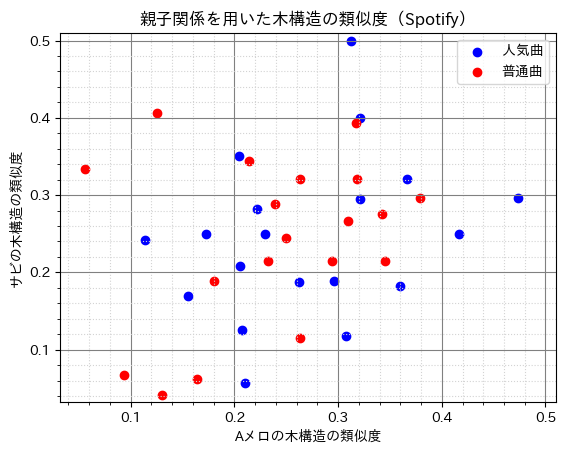

In [12]:
scatter(rates, xy_min_tspc, xy_max_tspc, ["spotify_id"], "spotify_popularity", "親子関係を用いた木構造の類似度（Spotify）", "Aメロの木構造の類似度", "サビの木構造の類似度")